In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
engagement = pd.read_csv('takehome_user_engagement.csv')
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [8]:
print(engagement['user_id'].nunique())

8823


In [9]:
engagement['time_stamp'] = pd.to_datetime(
    engagement['time_stamp'], format='%Y-%m-%d %H:%M:%S'
)

In [10]:
def logins_in_days(df, days=7, logins=3):
    from datetime import timedelta
    # first drop duplicate days and sort by day
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    # calculate how many days has passed for every 3 logins
    passed_days = df['date'].diff(periods=logins-1)
    # check if any passed time is less than 7 days
    return any(passed_days <= timedelta(days=days))

In [11]:
adopted = engagement.groupby('user_id').apply(logins_in_days)
adopted.name = 'adopted_user'

In [13]:
print(sum(adopted))

1656


In [18]:
cols = ['object_id', 'creation_source', 'creation_time', 
        'last_session_creation_time', 'opted_in_to_mailing_list',
        'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']
users = pd.read_csv('takehome_users.csv', usecols=cols, encoding = 'latin-1')
users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [19]:
users['org_id'].value_counts().head()

0    319
1    233
2    201
3    168
4    159
Name: org_id, dtype: int64

In [20]:
users['invited_by_user_id'].value_counts().head()

10741.0    13
2527.0     12
1525.0     11
11770.0    11
2308.0     11
Name: invited_by_user_id, dtype: int64

In [21]:
users = users.drop(['org_id', 'invited_by_user_id'], axis=1)

In [22]:

users['creation_time'] = pd.to_datetime(
    users['creation_time'], format='%Y-%m-%d %H:%M:%S')
users['last_session_creation_time'] = pd.to_datetime(
    users['last_session_creation_time'], unit='s')

users['history'] = users['last_session_creation_time'] - users['creation_time']
users['history'] = users['history'].dt.days

latest = max(users['creation_time'])
users['account_age'] = latest - users['creation_time']
users['account_age'] = users['account_age'].dt.days

users = users.drop(['creation_time', 'last_session_creation_time'], axis=1)

In [23]:
users = users.set_index('object_id')
users.index.name = 'user_id'
data = pd.concat([users, adopted], axis=1, join='inner')
data['adopted_user'] = data['adopted_user'].astype(int)

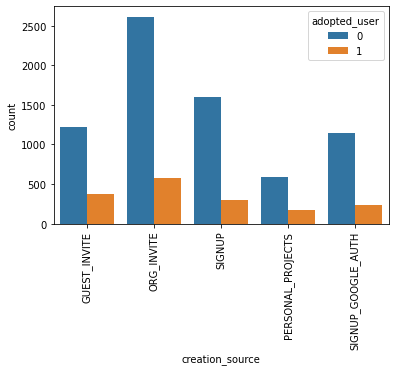

In [26]:
# Creation source and adopted user
_ = sns.countplot(x='creation_source', data=data, hue='adopted_user')

_ = plt.xticks(rotation=90)

In [28]:
# make dummy variable for creation source
creation_source = pd.get_dummies(data['creation_source'], drop_first=True)
model_data = pd.concat([data, creation_source], axis=1).drop('creation_source', axis=1)
y = model_data['adopted_user']
X = model_data.drop('adopted_user', axis=1)

from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, stratify=y, random_state=42)

In [29]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=42, class_weight='balanced')

params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 100}
Best average precision was 0.9623700369708137


In [30]:
# evluation of the model
from sklearn.metrics import classification_report, accuracy_score
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=100
)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print('Accuracy of test set was', accuracy_score(ytest, ypred))
print(classification_report(ytest, ypred))

Accuracy of test set was 0.9524025385312783
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1792
           1       0.88      0.86      0.87       414

    accuracy                           0.95      2206
   macro avg       0.92      0.92      0.92      2206
weighted avg       0.95      0.95      0.95      2206



In [32]:
# take a look at feature importance
importance = pd.Series(model.feature_importances_, index=X.columns)
importance = importance.sort_values(ascending=False)
print(importance)

history                       0.895648
account_age                   0.088648
opted_in_to_mailing_list      0.003301
SIGNUP                        0.003050
enabled_for_marketing_drip    0.002900
ORG_INVITE                    0.002355
PERSONAL_PROJECTS             0.002157
SIGNUP_GOOGLE_AUTH            0.001942
dtype: float64


These results indicate that the user history is the most important feature by far in determining the adopted users. In order to maximize adopted users, I would recommend having existing users log in and use the accounts after they have had accounts for a while. 